In [1]:
from underlying import Underlying
from option import Option
from trader import Trader

import matplotlib.pyplot as plt
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.integrate as integrate
from scipy.optimize import fsolve


In [126]:
def payoff_call(X, K):
    return np.maximum(X.iloc[:,-1]- K, 0)
def payoff_put(X, K):
    return np.maximum(K - X.iloc[:,-1], 0)

In [7]:
mu = 0.06
sigma =  0.3
r = 0.05
T = 1
X0 = 100
repeat = 100


In [8]:
mu_tilde = 0.07
sigma_tilde = 0.02
rho = 0.99
S0 = 100
K = 70

**Call i Put**

In [9]:
def dP_dQ(mu, sigma, T, r, W_T): 
    return np.exp(W_T * (mu-r) / sigma + 0.5 * T * ((mu - r) / sigma) ** 2)
# 0< x < \infty
def G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    return dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde) * norm.cdf((np.log((K+x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2))))

def derivative_G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    return np.exp(-(np.log((K+x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 / (2 * sigma ** 2 * T * (1 - rho ** 2)))/((K + x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi)) * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
# 0 < x < K
def G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K :
        raise Exception("x should be greater than 0 and smaller than K")
    return dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde) * (1 -norm.cdf((np.log((K-x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2)))))

def derivative_G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K :
        raise Exception("x should be greater than 0 and smaller than K")
    return np.exp(-(np.log((K-x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 / (2 * sigma ** 2 * T * (1 - rho ** 2)))/((K- x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi)) * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

Bez dP_dQ

In [131]:
def G_call_basic_wo_const(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    return norm.cdf((np.log((K + x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2))))

def derivative_G_call_basic_wo_const(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    return np.exp(-(np.log((K + x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 / (2 * sigma ** 2 * T * (1 - rho ** 2))) / ((K + x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi))
# 0 < x < K
def G_put_basic_wo_const(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K :
        raise Exception("x should be greater than 0 and smaller than K")
    return 1 - norm.cdf((np.log((K - x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde)/ (sigma * np.sqrt(T * (1 - rho ** 2))))

def derivative_G_put_basic_wo_const(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K :
        raise Exception("x should be greater than 0 and smaller than K")
    return np.exp(-(np.log((K - x)/S0) - mu * T + 0.5 * sigma ** 2 * T - sigma * rho * W_T_tilde) ** 2 /  (2 * sigma ** 2 * T * (1 - rho ** 2)))/((K - x) * sigma * np.sqrt(T * (1 - rho ** 2 ) * 2 * np.pi))

Druga Funkcja Celu

In [238]:
def integrand_call(y, S0, mu, sigma, rho, W_T_tilde, K, T):
    return 1 / np.sqrt(np.pi * 2 * T) / (S0 * np.exp(mu * T + sigma * W_T_tilde * rho + np.sqrt(1 - rho ** 2) * sigma * y - 0.5 * sigma ** 2 * T) - K) * np.exp(y ** 2 / (-2 * T) )

def G2_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    g1 = G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    a = (np.log((K + x)/ S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
    g2 = x * integrate.quad(integrand_call, a, np.inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T))[0]
    return g1 + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

def derivative_G2_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0:
        raise Exception("x should be greater than 0")
    g1 = derivative_G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    a = (np.log((K + x)/ S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
    g2 = integrate.quad(integrand_call, a, np.inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T))[0]
    return g1 + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

def integrand_put(y, S0, mu, sigma, rho, W_T_tilde, K, T):
    return 1 / np.sqrt(np.pi * 2 * T) / (K - S0 * np.exp(mu * T + sigma * W_T_tilde * rho + np.sqrt(1 - rho ** 2) * sigma * y - 0.5 * sigma ** 2 * T)) * np.exp(y ** 2 / (-2 * T) )

def G2_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K:
        raise Exception("x should be greater than 0")
    g1 = G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    b = (np.log((K - x) / S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 - rho ** 2))
    g2 = x * integrate.quad(integrand_put, -np.inf, b, args = (S0, mu, sigma, rho, W_T_tilde, K, T), limit = 10 ** 4 )[0]
    return g1 + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

def derivative_G2_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    if x <= 0 or x >= K:
        raise Exception("x should be greater than 0")
    g1 = derivative_G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    b = (np.log((K - x) / S0)  - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 - rho ** 2))
    g2 = integrate.quad(integrand_put, -np.inf, b, args = (S0, mu, sigma, rho, W_T_tilde, K, T), limit = 10 ** 4)[0]
    return g1  + g2 * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

In [239]:
W_T_tilde = 7

<Axes: xlabel='x'>

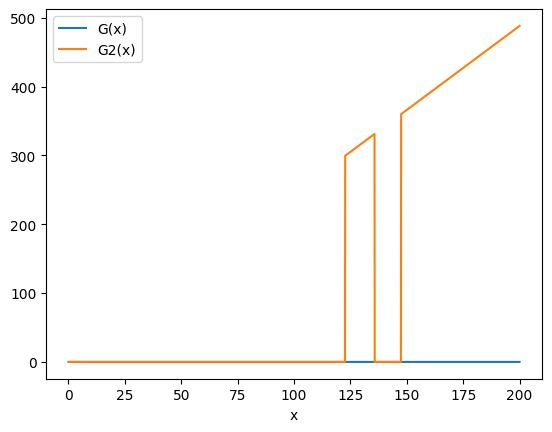

In [240]:
x_range = 200
delta = 0.1
x_call = np.arange(delta, x_range + delta, delta)
df_call = pd.DataFrame({ "x" : x_call, "G(x)" : np.zeros(len(x_call)), "G2(x)" : np.zeros(len(x_call)), "a" : None})
for i in range(len(x_call)):
    df_call.at[i, "G(x)"] = G_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_call.at[i, "G2(x)"] = G2_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
df_call.plot(x = 'x', y = [1,2])

In [243]:
W_T_tilde = 2
x_range = 200
delta = 0.1
x_call = np.arange(delta, x_range + delta, delta)
x_put = np.arange(delta, K, delta)
df_call = pd.DataFrame({ "x" : x_call, "G2(x)" : np.zeros(len(x_call)), "G(x)" : np.zeros(len(x_call))})
for i in range(len(x_call)):
    df_call.at[i, "G2(x)"] = G2_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_call.at[i, "G(x)"] = G_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
df_put = pd.DataFrame({ "x" : x_put, "G2(x)" : np.zeros(len(x_put)), "G(x)" : np.zeros(len(x_put))})
for i in range(len(x_put)):
    df_put.at[i, "G2(x)"] = G2_put_basic(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_put.at[i, "G(x)"] = G_put_basic(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)

In [244]:
df_call["num d/dx"] = (df_call["G2(x)"].shift(-1)-df_call["G2(x)"])/delta
df_put["num d/dx"] = (df_put["G2(x)"].shift(-1)-df_put["G2(x)"])/delta

<Axes: xlabel='x'>

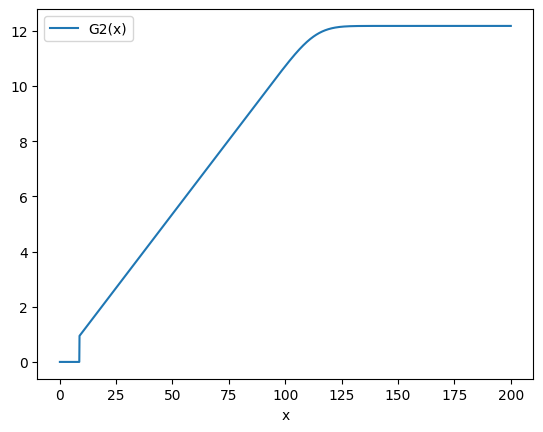

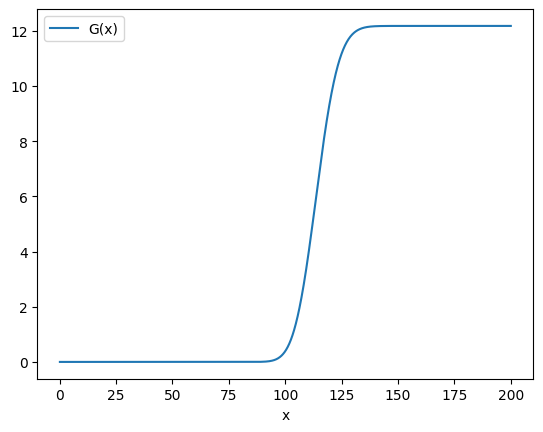

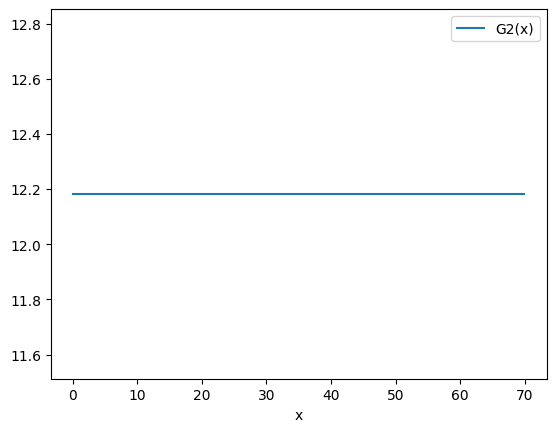

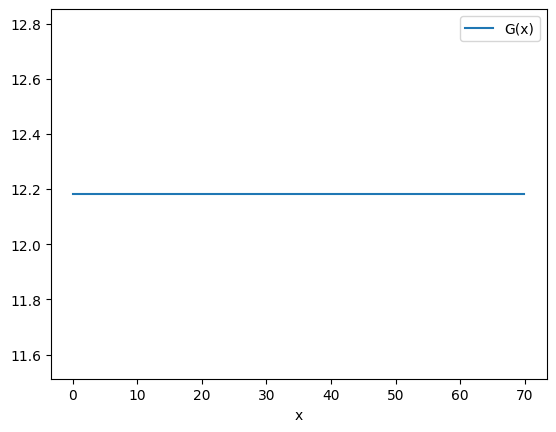

In [245]:
df_call.plot(x = 'x', y = 1)
df_call.plot(x = 'x', y = [2])
df_put.plot(x = 'x', y = 1)
df_put.plot(x = 'x', y = [2])

*Test*

In [228]:
#W_T_tilde = np.random.normal()
W_T_tilde = -0.9
#W_T_tilde = 1
#W_T_tilde = 5
#m = 0.0005 
#m = 0.003
m = 0.05

In [229]:
dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)

0.6703200460356393

**bez dP/dP**

In [231]:
x_range = 500
delta = 0.01
x_call = np.arange(delta, x_range + delta, delta)
x_put = np.arange(delta, K, delta)
df_call = pd.DataFrame({ "x" : x_call, "G(x)" : np.zeros(len(x_call)), "d/dx G(x)" : np.zeros(len(x_call))})
df_put = pd.DataFrame({ "x" : x_put, "G(x)" : np.zeros(len(x_put)), "d/dx G(x)" : np.zeros(len(x_put))})
for i in range(len(x_call)):
    df_call.at[i, "G(x)"] = G_call_basic_wo_const(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_call.at[i, "d/dx G(x)"] = derivative_G_call_basic_wo_const(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
for i in range(len(x_put)):
    df_put.at[i, "G(x)"] = G_put_basic_wo_const(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_put.at[i, "d/dx G(x)"] = derivative_G_put_basic_wo_const(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)

NameError: name 'G_call_basic_wo_const' is not defined

***numerical derivative***

*test plot*

In [232]:
x_range = 100
delta = 0.01
x_call = np.arange(delta, x_range + delta, delta)
x_put = np.arange(delta, K, delta)
df_call = pd.DataFrame({ "x" : x_call, "G(x)" : np.zeros(len(x_call)), "d/dx G(x)" : np.zeros(len(x_call))})
df_put = pd.DataFrame({ "x" : x_put, "G(x)" : np.zeros(len(x_put)), "d/dx G(x)" : np.zeros(len(x_put))})
for i in range(len(x_call)):
    df_call.at[i, "G(x)"] = G_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_call.at[i, "d/dx G(x)"] = derivative_G_call_basic(df_call.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
for i in range(len(x_put)):
    df_put.at[i, "G(x)"] = G_put_basic(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    df_put.at[i, "d/dx G(x)"] = derivative_G_put_basic(df_put.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)

df_call["num d/dx"] = (df_call["G(x)"].shift(-1)-df_call["G(x)"])/delta
df_put["num d/dx"] = (df_put["G(x)"].shift(-1)-df_put["G(x)"])/delta

Znajdowanie $x$ takiego, że $G'(x)=m$

In [ ]:
def get_coefficients(m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho):
    m_tilde = m / dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
    a = 1
    b = 2 * sigma ** 2 * T * (1 - rho ** 2 ) - 2 * np.log(S0) - 2 * mu * T + sigma ** 2 * T - 2 * rho * sigma * W_T_tilde
    c = np.log(m_tilde * sigma * np.sqrt(2 * np.pi * T * (1 - rho ** 2))) * (2 * sigma ** 2 * T * (1 - rho ** 2 )) + (-np.log(S0) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) ** 2 
    return a, b, c

def get_delta(a, b, c):
    return b ** 2 - 4 * a * c

def find_x_analytical(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0,  rho, type = 'call', grid_step = 0.01, fun = 1):
    if fun == 2:
        if type == 'call':
            a = (np.log(K + x) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
            integral = integrate.quad(integrand_call, a, np.inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T))[0] * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
        else :
            b = (np.log(K - x) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 - rho ** 2))
            integral = integrate.quad(integrand_put, -np.inf, b, args = (S0, mu, sigma, rho, W_T_tilde, K, T), limit = 10 ** 4)[0] * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
        m = m - integral
        if m < 0:
            return 0 
    coef = get_coefficients(m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    delta = get_delta(*coef)
    if delta < 0:
        #print('DELTA < 0')
        return 0
    elif delta == 0:
        #print('DELTA RÓWNA 0')
        if type == 'call':
            x = (np.exp( -1 * coef[1] / (2 * coef[0])) - K)
        else:
            x = -(np.exp( -1 * coef[1] / (2 * coef[0])) - K)
    else:
        ## Delta daje dwa rozwy, ale biorę ten większy, bo ma być nad funkcją
        if type == 'call':
            #x = ( (np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) - K),(np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K) )
            x = np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K
        else:
            #x = ( -(np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K), -(np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) - K) )
            x = -np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) + K
    if x < 0:
        return 0
    # sprawdzenie czy prosta styczna przechodzi jest cały czas nad
    if type == 'call':
        b = G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
        if G_call_basic(grid_step, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) -m * grid_step - b > 0:
            return 0
    else:
        b = G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
        if  G_put_basic(grid_step, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) -m * grid_step - b > 0:
            return 0

    return x


In [ ]:
def find_x_analytical2(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0,  rho, type = 'call', grid_step = 0.01):
    if type - 'call':
        a = (np.log(K + x) - mu * T + sigma ** 2 * T * 0.5 - rho * sigma * W_T_tilde) / (sigma * np.sqrt(1 -rho ** 2))
        integral = integrate.quad(integrand_call, a, np.inf, args = (S0, mu, sigma, rho, W_T_tilde, K, T))[0] * dP_dQ(mu_tilde, sigma_tilde, T, r, W_T_tilde)
    else :
        pass
    m = m - integral
    if m < 0:
        return 0 
    coef = get_coefficients(m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
    delta = get_delta(*coef)
    if delta < 0:
        #print('DELTA < 0')
        return 0
    elif delta == 0:
        #print('DELTA RÓWNA 0')
        if type == 'call':
            x = (np.exp( -1 * coef[1] / (2 * coef[0])) - K)
        else:
            x = -(np.exp( -1 * coef[1] / (2 * coef[0])) - K)
    else:
        ## Delta daje dwa rozwy, ale biorę ten większy, bo ma być nad funkcją
        if type == 'call':
            #x = ( (np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) - K),(np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K) )
            x = np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K
        else:
            #x = ( -(np.exp(( -1 * coef[1] + np.sqrt(delta)) / (2 * coef[0] )) - K), -(np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) - K) )
            x = -np.exp(( -1 * coef[1] - np.sqrt(delta)) / (2 * coef[0] )) + K
    if x < 0:
        return 0
    # sprawdzenie czy prosta styczna przechodzi jest cały czas nad
    if type == 'call':
        b = G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
        if G_call_basic(grid_step, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) -m * grid_step - b > 0:
            return 0
    else:
        b = G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
        if  G_put_basic(grid_step, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) -m * grid_step - b > 0:
            return 0

    return x

In [ ]:
find_x_analytical(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', grid_step = 0.01)

10.871290383180067

In [ ]:
find_x_analytical(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'put', grid_step = 0.01)

0

In [ ]:
def plot_line(x, m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 50, kind_of_plot = 'diff'):
    if type == 'put' and  x_range > K:
        x_range = K
    x_grid = np.arange(grid_step, x_range, grid_step)
    df = pd.DataFrame({ "x" : x_grid, "G(x)" : np.zeros(len(x_grid)), "Line" : np.zeros(len(x_grid)), "Diff" : np.zeros(len(x_grid))})
    for i in range(len(x_grid)):
        if type == 'call':
            b = G_call_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
            df.at[i, "G(x)"] = G_call_basic(df.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
            df.at[i, "Line"] = m * df.at[i, 'x'] + b
            df.at[i, "Diff"] = df.at[i, "Line"] - df.at[i, "G(x)"] 

        else:
            b = G_put_basic(x, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho) - m * x
            df.at[i, "G(x)"] = G_put_basic(df.at[i, 'x'], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho)
            df.at[i, "Line"] = m * df.at[i, 'x'] + b
            df.at[i, "Diff"] = df.at[i, "Line"] - df.at[i, "G(x)"] 
    #df.plot(x = 'x', y = [1,2])
    if kind_of_plot == 'diff':
        df.plot(x = 'x', y = [3])
    else:
        df.plot(x = 'x', y = [1,2])
    return 0
    
       


0

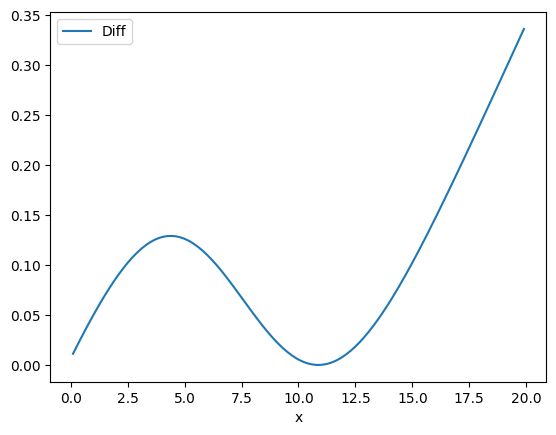

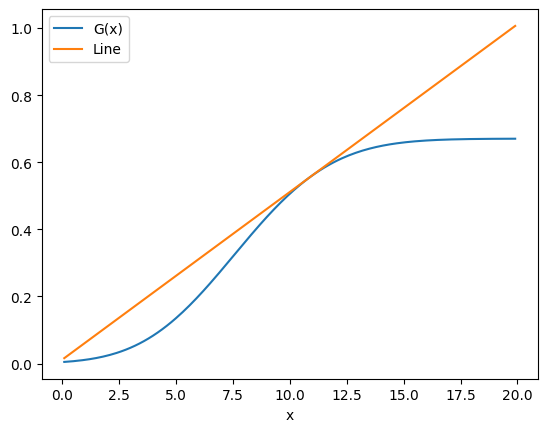

In [ ]:
plot_line(find_x_analytical(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', grid_step = 0.01), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 20, kind_of_plot = 'diff')
plot_line(find_x_analytical(m, W_T_tilde, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', grid_step = 0.01), m, mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, W_T_tilde, rho, type = 'call', grid_step = 0.1, x_range = 20, kind_of_plot = "G(x) and line")

In [ ]:
n = 10 ** 4
W_T_tilde_vec = np.random.normal(size = n)
m_vec = np.arange(0.01,1,0.01)
df_m = pd.DataFrame({"m": m_vec, "Mean": None, "Prob": None})

In [ ]:
df = pd.DataFrame({ "W_T_tilde" : W_T_tilde_vec, "x" : 0, "Prob" : 0})

Ten syf poprawic, "odforowic" i oprawic w funkcje i dac puta

In [ ]:
for j in range(df_m.shape[0]):
    #po prostu zmodyfikuj df bez fora
    for i in range(df.shape[0]):
        df.iloc[i,1] = find_x_analytical(df_m.iloc[j,0], df.iloc[i,0], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', grid_step = 0.01)
        df.iloc[i,2] = norm.cdf((np.log((df.iloc[i,1] + K) / S0) - mu * T )/ sigma / np.sqrt(T))#call
    #to też się da
    df_m.iloc[j, 1] = df['x'].mean()
    df_m.iloc[j, 2] = df['Prob'].mean()
    

In [ ]:
df_m

,m,Mean,Prob
0,0.01,47.047814,0.544601
1,0.02,45.596058,0.532205
2,0.03,44.644906,0.523904
3,0.04,39.211921,0.464434
4,0.05,21.361145,0.266028
...,...,...,...
94,0.95,0.0,0.082429
95,0.96,0.0,0.082429
96,0.97,0.0,0.082429
97,0.98,0.0,0.082429


<Axes: xlabel='m'>

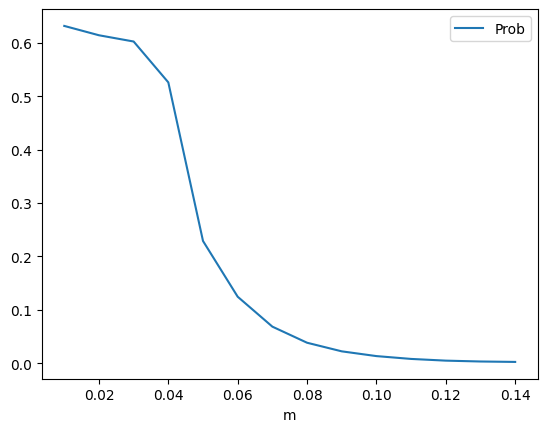

In [ ]:
df_m.plot(x = 'm', y = 'Prob')

**Zmiana rho**

In [ ]:
rho = 0.3

In [ ]:
for j in range(df_m.shape[0]):
    for i in range(df.shape[0]):
        df.iloc[i,1] = find_x_analytical(df_m.iloc[j,0], df.iloc[i,0], mu, sigma, mu_tilde, sigma_tilde, r, T, K, S0, rho, type = 'call', grid_step = 0.01)
    df_m.iloc[j, 1] = df['x'].mean() 

In [ ]:
1 - 0.9**2

0.18999999999999995

<Axes: xlabel='m'>

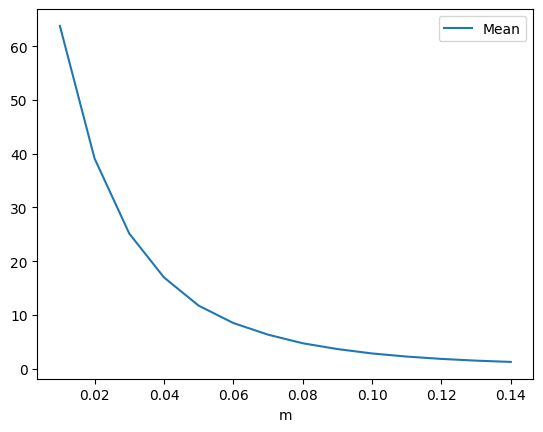

In [ ]:
df_m.plot(x = 'm', y = 'Mean')